<a href="https://www.kaggle.com/code/sarwar92/image-captioning-fliker8k-densenet?scriptVersionId=223588095" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import os
import json
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
# Add these imports at the top with other imports
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction


plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')
tf.keras.mixed_precision.set_global_policy('mixed_float16')



# **Image Captioning**

**What is Image Captioning ?**
- Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.
- This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.

**CNNs + RNNs (LSTMs)**
- To perform Image Captioning we will require two deep learning models combined into one for the training purpose
- CNNs extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction
- LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word
- For a more illustrative explanation of this architecture check the Modelling section for a picture representation

<img src="https://miro.medium.com/max/1400/1*6BFOIdSHlk24Z3DFEakvnQ.png">

In [2]:
image_path = '/kaggle/input/flickr8k/Images'
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

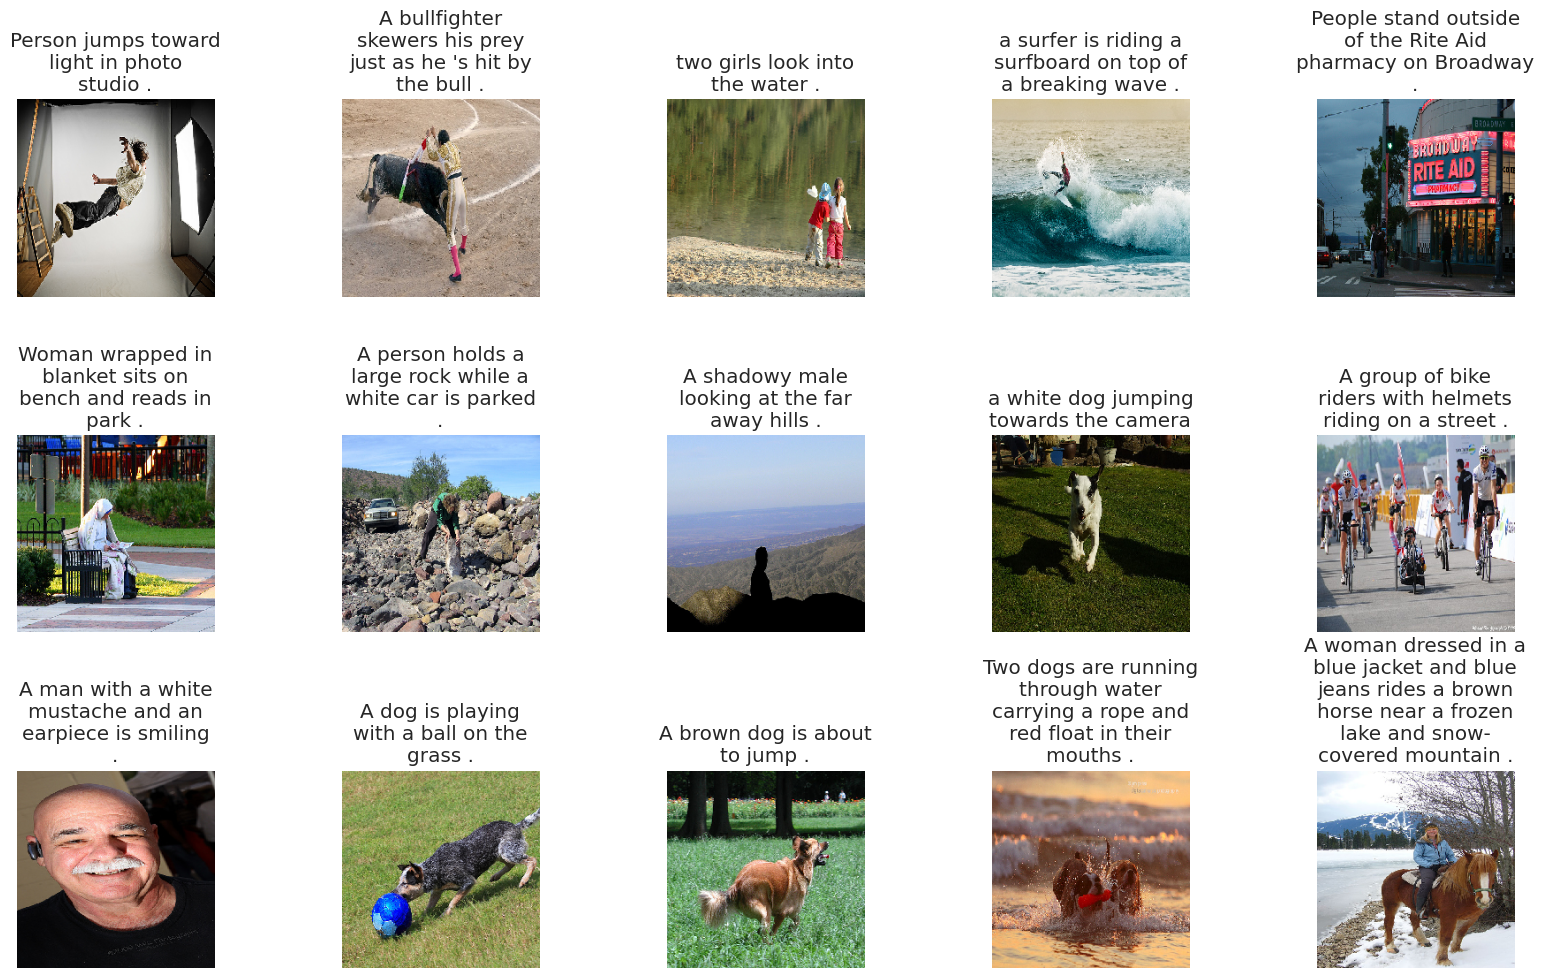

In [3]:
# block 3 image processing and display 
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

display_images(data.sample(15))


# **Caption Text Preprocessing Steps**
- Convert sentences into lowercase
- Remove special characters and numbers present in the text
- Remove extra spaces
- Remove single characters
- Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

<img src='http://zjpnrm2br14wspo448nls17u-wpengine.netdna-ssl.com/wp-content/uploads/2020/09/processing-steps.png' >

In [4]:
# block 4
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"

    return data 
    
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## __Preprocessed Text__

## __Tokenization and Encoded Representation__
- The words in a sentence are separated/tokenized and encoded in a one hot representation
- These encodings are then passed to the embeddings layer to generate word embeddings

<img src='https://lena-voita.github.io/resources/lectures/word_emb/lookup_table.gif'>

In [5]:
# block 6
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]


[1, 18, 315, 63, 195, 116, 2]

# **Image Feature Extraction**
- DenseNet 201 Architecture is used to extract the features from the images
- Any other pretrained architecture can also be used for extracting features from these images
- Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920

<img src="https://imgur.com/wWHWbQt.jpg">

In [6]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


100%|██████████| 8091/8091 [10:55<00:00, 12.34it/s]


# **Data Generation**
- Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
- The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
- The text embeddings are passed word by word for the caption generation during inference time

In [7]:
# block 8
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

# Test tokenizer by converting a single caption to a sequence
example_sequence = tokenizer.texts_to_sequences([captions[1]])[0]
print("Example sequence:", example_sequence)


Example sequence: [1, 18, 315, 63, 195, 116, 2]


In [8]:
train_generator[0]

((array([[7.850e-05, 7.348e-04, 1.139e-03, ..., 5.659e-01, 2.297e-01,
          6.973e-01],
         [7.850e-05, 7.348e-04, 1.139e-03, ..., 5.659e-01, 2.297e-01,
          6.973e-01],
         [7.850e-05, 7.348e-04, 1.139e-03, ..., 5.659e-01, 2.297e-01,
          6.973e-01],
         ...,
         [1.948e-04, 7.029e-04, 1.494e-03, ..., 2.744e-02, 5.586e-01,
          3.906e-01],
         [1.948e-04, 7.029e-04, 1.494e-03, ..., 2.744e-02, 5.586e-01,
          3.906e-01],
         [1.948e-04, 7.029e-04, 1.494e-03, ..., 2.744e-02, 5.586e-01,
          3.906e-01]], dtype=float16),
  array([[  0,   0,   0, ...,   0,   0,   1],
         [  0,   0,   0, ...,   0,   1,  42],
         [  0,   0,   0, ...,   1,  42,   3],
         ...,
         [  0,   0,   0, ...,  10,  76,  49],
         [  0,   0,   0, ...,  76,  49,   4],
         [  0,   0,   0, ...,  49,   4, 210]], dtype=int32)),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.,

# **Modelling**
- The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network 
- The LSTM network starts generating words after each input thus forming a sentence at the end

<img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png'>

## **Let's train the Model !**

<img src='https://miro.medium.com/max/1400/1*xIXqf46yYonSXkUOWcOCvg.gif'>

In [10]:
# block 9
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')


from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint
model_name = "model.keras"  # Update the extension to .keras
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)




history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])
# Model summary
caption_model.summary()





Epoch 1/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 5.9080
Epoch 1: val_loss improved from inf to 4.29611, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 82s 147ms/step - loss: 5.9052 - val_loss: 4.2961 - learning_rate: 0.0010
Epoch 2/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 4.3333
Epoch 2: val_loss improved from 4.29611 to 3.95775, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 79s 145ms/step - loss: 4.3331 - val_loss: 3.9578 - learning_rate: 0.0010
Epoch 3/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 4.0422
Epoch 3: val_loss improved from 3.95775 to 3.80815, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 76s 141ms/step - loss: 4.0421 - val_loss: 3.8082 - learning_rate: 0.0010
Epoch 4/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 3.8428
Epoch 4: val_loss improved from 3.80815 to 3.71457, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 79s 146ms/step - loss: 3.8428 - val_loss: 3.7146 - learning_rate: 0.0010


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 1920)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_2 (Cast)             │ (None, 1920)           │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        491,776 │ cast_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 256)         │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 34, 256)        │      2,172,160 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 35, 256)        │              0 │ reshape_1[0][0],       │
│ (Concatenate)             │                        │                │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 256)            │        525,312 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256)            │              0 │ dropout_2[0][0],       │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         32,896 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 8485)           │      1,094,565 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,950,133 (49.40 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,633,424 (32.93 MB)

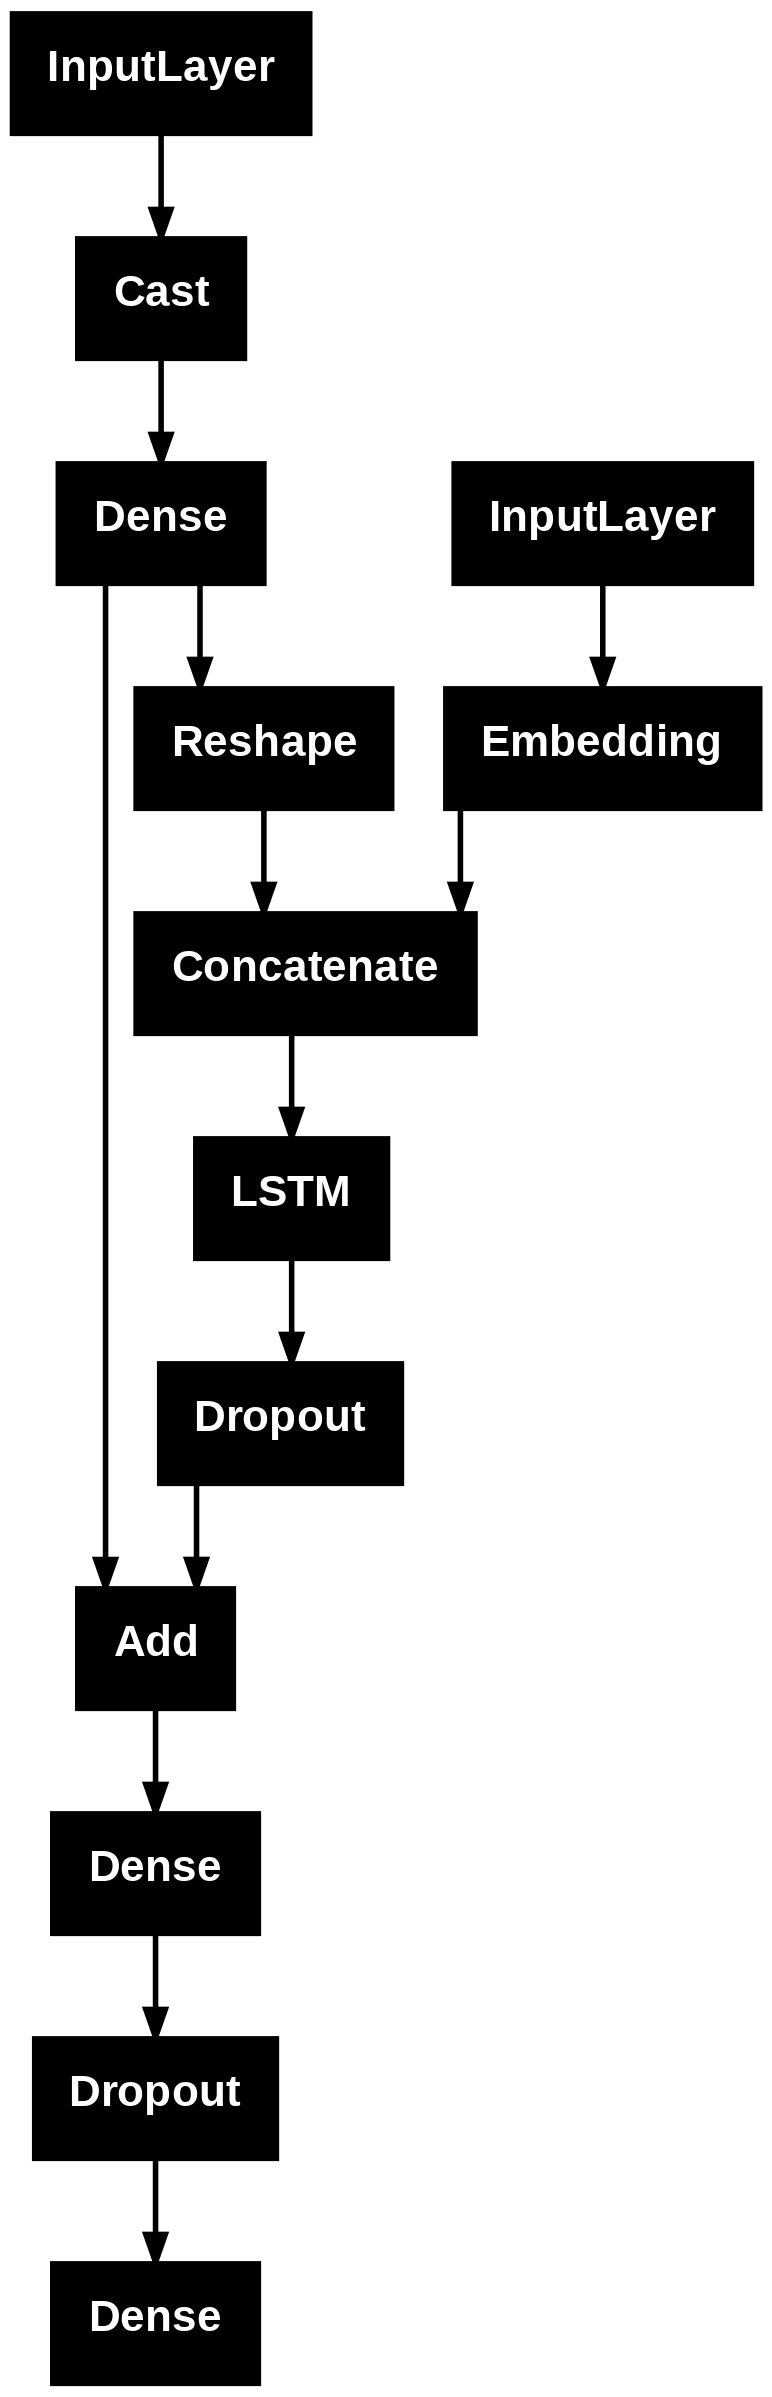

In [42]:
plot_model(caption_model)

## **Let's train the Model !**

<img src='https://miro.medium.com/max/1400/1*xIXqf46yYonSXkUOWcOCvg.gif'>

# **Inference**
- Learning Curve (Loss Curve)
- Assessment of Generated Captions (by checking the relevance of the caption with respect to the image, BLEU Score will not be used in this kernel)

## **Learning Curve**
- The model has clearly overfit, possibly due to less amount of data
- We can tackle this problem in two ways
    1. Train the model on a larger dataset Flickr40k
    2. Attention Models

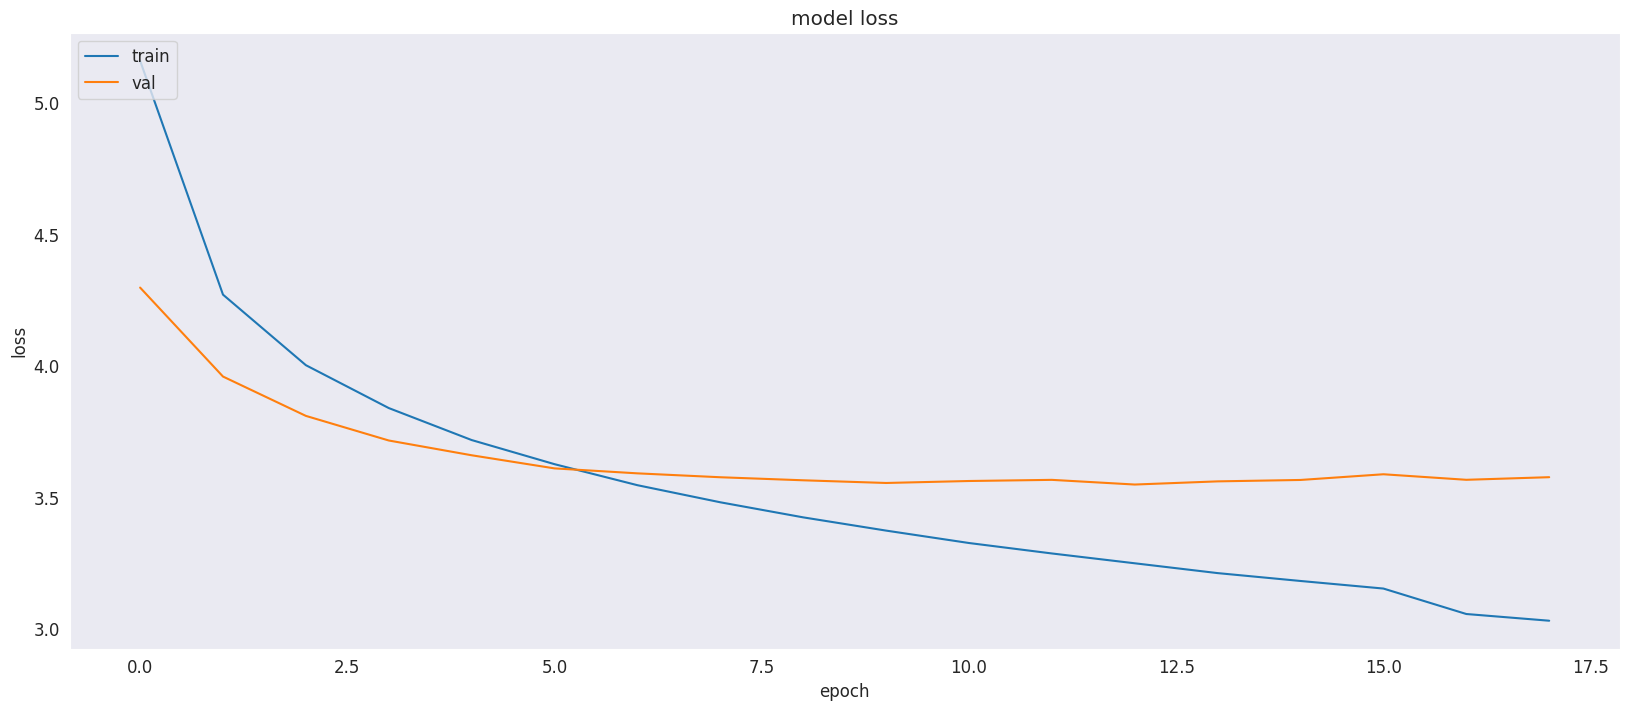

In [12]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Caption Generation Utility Functions

- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text
- embedding of each new word is passed to generate the next word.


In [13]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
fe.save("feature_extractor.keras")

# Save history
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [14]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"



def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features
    
    # Generate the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

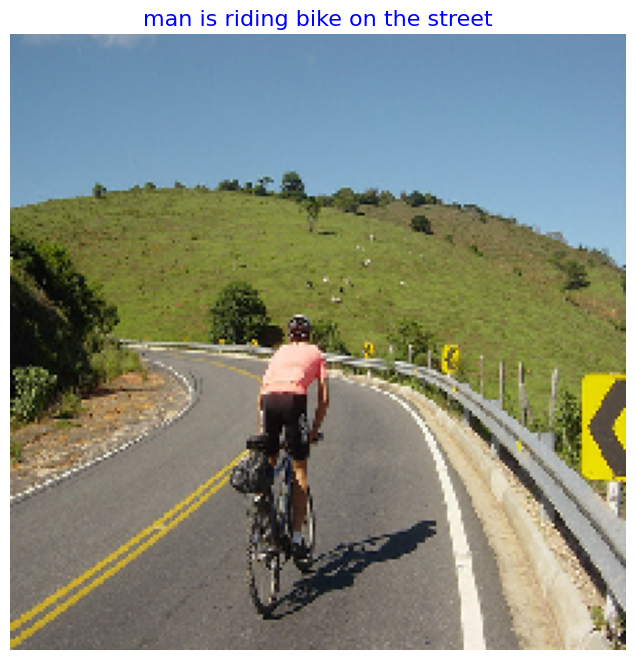

In [15]:
# Example usage
image_path = "/kaggle/input/flickr8k/Images/110595925_f3395c8bd6.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)


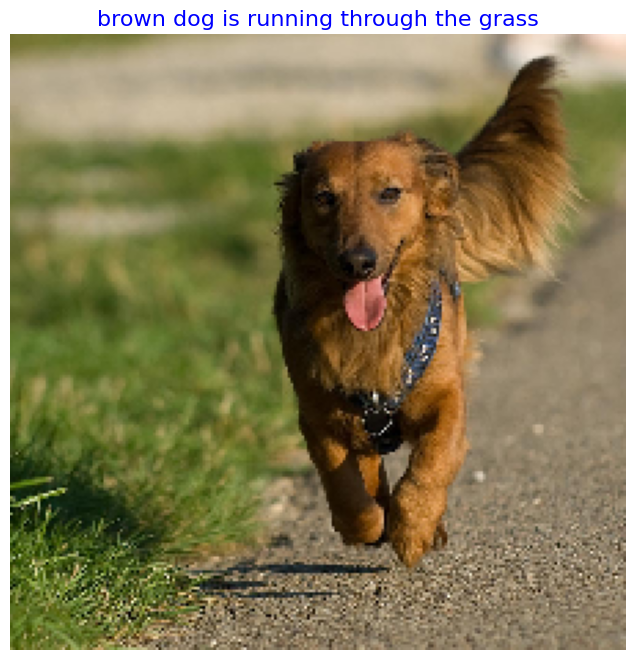

In [16]:
image_path = "/kaggle/input/flickr8k/Images/1089181217_ee1167f7af.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)


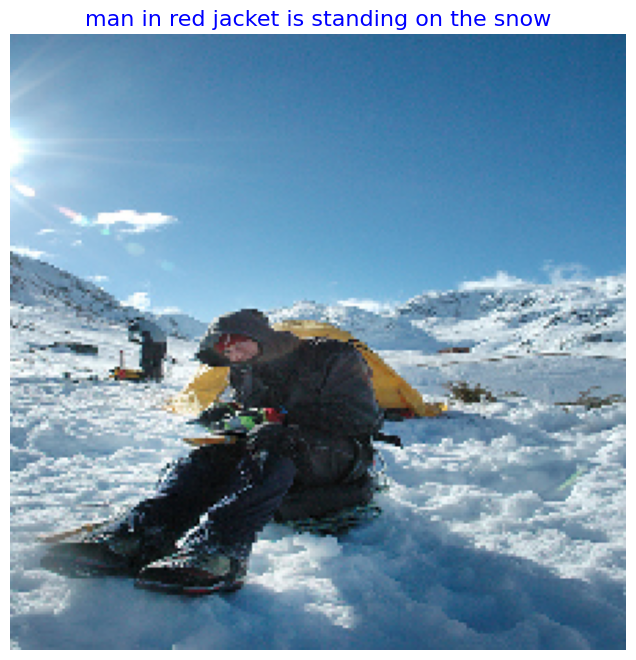

In [17]:
image_path = "/kaggle/input/flickr8k/Images/116409198_0fe0c94f3b.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)


In [18]:
import os
import pickle
import numpy as np
import pandas as pd
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tqdm import tqdm
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Download necessary NLTK data
nltk.download('punkt')

# Define a function to generate captions without displaying images
def generate_caption(image_path, model, tokenizer, feature_extractor, max_length, img_size=224):
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)
    
    in_text = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, '')
        if word == '' or word == 'endseq':
            break
        in_text += ' ' + word
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()
    return caption

# Load models and tokenizer
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"

caption_model = load_model(model_path)
feature_extractor = load_model(feature_extractor_path)

with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

# Ensure image path is defined
image_path = '/kaggle/input/flickr8k/Images'

# Prepare references and hypotheses
references = []
hypotheses = []

# Compute max_length properly
captions = train['caption'].dropna().tolist()  # Ensure there are no NaNs and use train dataset
max_length = max(len(caption.split()) for caption in captions) if captions else 0

# Process test images
test_images = test['image'].unique()
for image_name in tqdm(test_images, desc="Generating Captions"):
    img_path = os.path.join(image_path, image_name)
    
    
    if not os.path.exists(img_path):
        print(f"Warning: Image not found: {img_path}, skipping.")
        continue
    
    # Generate caption
    caption = generate_caption(img_path, caption_model, tokenizer, feature_extractor, max_length)
    hypotheses.append(caption.split())
    
    # Get references
    refs = test[test['image'] == image_name]['caption'].tolist()
    processed_refs = [ref.replace('startseq', '').replace('endseq', '').strip().split() for ref in refs]
    references.append(processed_refs)



[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Generating Captions: 100%|██████████| 1214/1214 [11:24<00:00,  1.77it/s]


In [19]:
# Serialize references using pickle
with open("references.pkl", "wb") as f:
    pickle.dump(references, f)

In [20]:
# Compute BLEU scores with smoothing
# Example of loading the references later:
with open("references.pkl", "rb") as f:
    loaded_references = pickle.load(f)

smoothie = SmoothingFunction().method5
bleu_1 = corpus_bleu(loaded_references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smoothie)
bleu_2 = corpus_bleu(loaded_references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
bleu_3 = corpus_bleu(loaded_references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
bleu_4 = corpus_bleu(loaded_references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

print(f"BLEU-1: {bleu_1:.4f}")
print(f"BLEU-2: {bleu_2:.4f}")
print(f"BLEU-3: {bleu_3:.4f}")
print(f"BLEU-4: {bleu_4:.4f}")
# Save BLEU scores to a JSON file 
normal_bleu_scores = { 
    "BLEU-1": bleu_1, 
    "BLEU-2": bleu_2, 
    "BLEU-3": bleu_3, 
    "BLEU-4": bleu_4 
} 
with open("normal_bleu_scores.json", "w") as json_file: 
    json.dump(normal_bleu_scores, json_file) 
print("BLEU scores saved to normal_bleu_scores.json")

BLEU-1: 0.7540
BLEU-2: 0.5083
BLEU-3: 0.3377
BLEU-4: 0.2127
BLEU scores saved to normal_bleu_scores.json


In [21]:
def generate_caption_greedy(model, image_features, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image_features, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat, None)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

In [22]:



# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"
image_path = '/kaggle/input/flickr8k/Images'
def extract_image_features(image_path, feature_extractor, img_size):
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    return feature_extractor.predict(img, verbose=0)  # Extract image features
def calculate_bleu_score(reference_captions, generated_caption):
    reference_captions = [ref.split() for ref in reference_captions]
    generated_caption = generated_caption.split()
    return sentence_bleu(reference_captions, generated_caption)



def generate_and_display_caption_using_greedy(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Extract image features
    image_features = extract_image_features(image_path, feature_extractor, img_size)
    
    # Generate caption using greedy search
    caption = generate_caption_greedy(caption_model, image_features, tokenizer, max_length)
    caption = caption.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    display_captioned_image(image_path, caption, img_size)

In [23]:
def display_captioned_image(image_path, caption, img_size):
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{caption}", fontsize=16, color='blue')
    plt.show()

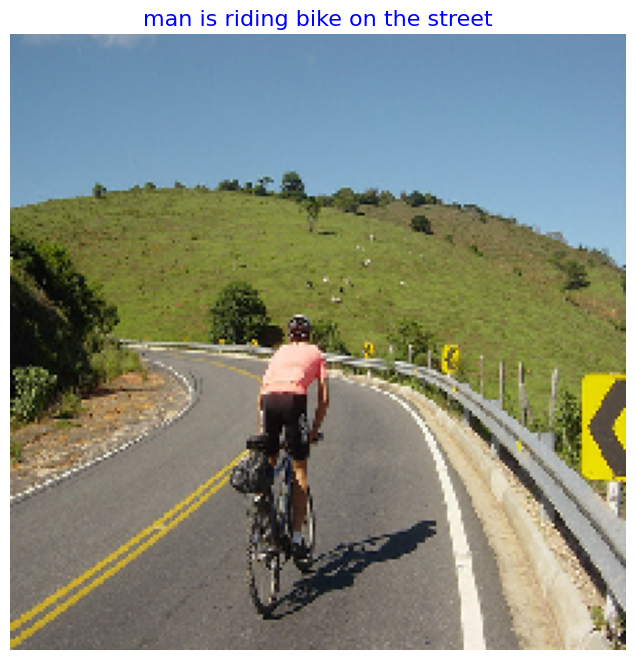

In [24]:
image_path = "/kaggle/input/flickr8k/Images/110595925_f3395c8bd6.jpg"  # Replace with the path to the input image
generate_and_display_caption_using_greedy(image_path, model_path, tokenizer_path, feature_extractor_path)

In [25]:

# Beam Search Captioning
def generate_caption_beam_search(model, image_features, tokenizer, max_length, beam_width=3):
    start = [tokenizer.word_index['startseq']]
    sequences = [[start, 0.0]]
    while len(sequences[0][0]) < max_length:
        all_candidates = []
        for seq, score in sequences:
            sequence = pad_sequences([seq], maxlen=max_length)
            yhat = model.predict([image_features, sequence], verbose=0)
            top_indices = np.argsort(yhat[0])[-beam_width:]
            for idx in top_indices:
                word = tokenizer.index_word.get(idx, '')
                if word:
                    candidate = [seq + [idx], score - np.log(yhat[0][idx])]
                    all_candidates.append(candidate)
        sequences = sorted(all_candidates, key=lambda tup: tup[1])[:beam_width]
    final_sequence = sequences[0][0]
    caption = [tokenizer.index_word[i] for i in final_sequence if i in tokenizer.index_word]
    return ' '.join(caption)

In [26]:
def generate_and_display_caption_using_beam_search(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Extract image features
    image_features = extract_image_features(image_path, feature_extractor, img_size)
    
    # Generate caption using greedy search
    caption = generate_caption_beam_search(caption_model, image_features, tokenizer, max_length)
    caption = caption.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    display_captioned_image(image_path, caption, img_size)
    return caption

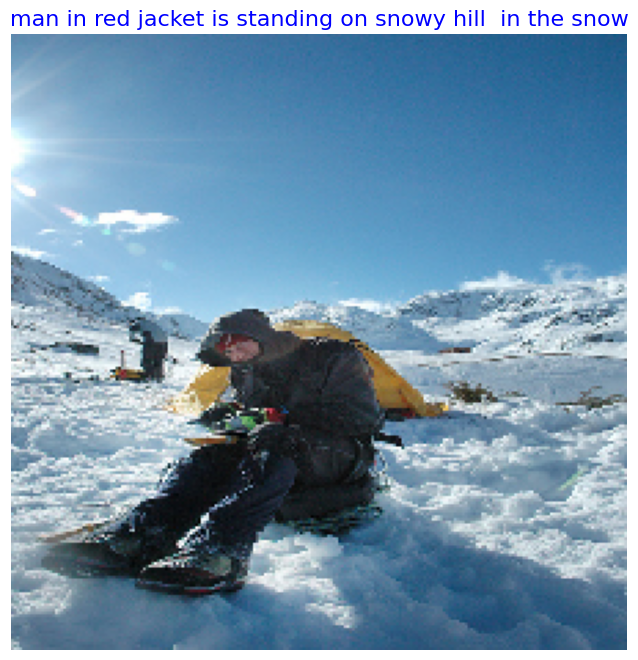

'man in red jacket is standing on snowy hill  in the snow'

In [27]:
image_path = "/kaggle/input/flickr8k/Images/116409198_0fe0c94f3b.jpg"  # Replace with the path to the input image
generate_and_display_caption_using_beam_search(image_path, model_path, tokenizer_path, feature_extractor_path)

In [28]:
def generate_caption(image_path, model_path, tokenizer_path, feature_extractor_path, reference_captions, method='greedy', beam_size=3, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Extract image features
    image_features = extract_image_features(image_path, feature_extractor, img_size)
    
    # Generate caption based on method
    if method == 'greedy':
        caption = generate_caption_greedy(caption_model, image_features, tokenizer, max_length)
    elif method == 'beam':
        caption = generate_caption_beam_search(caption_model, image_features, tokenizer, max_length, beam_size)
    else:
        raise ValueError("Invalid method. Choose 'greedy' or 'beam'")
    
    caption = caption.replace("startseq", "").replace("endseq", "").strip()

In [32]:
# Load models and tokenizer
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"

caption_model = load_model(model_path)
feature_extractor = load_model(feature_extractor_path)

with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

# Ensure image path is defined
image_path = '/kaggle/input/flickr8k/Images'

# Prepare references and hypotheses
references = []
hypotheses = []

# Compute max_length properly
captions = train['caption'].dropna().tolist()  # Ensure there are no NaNs and use train dataset
max_length = max(len(caption.split()) for caption in captions) if captions else 0

# Process test images
test_images = test['image'].unique()
for image_name in tqdm(test_images, desc="Generating Captions"):
    img_path = os.path.join(image_path, image_name)
    
    
    if not os.path.exists(img_path):
        print(f"Warning: Image not found: {img_path}, skipping.")
        continue
    
    # Generate caption
            # Extract image features
    image_features = extract_image_features(img_path, feature_extractor, img_size)
    
    # Generate caption using greedy search
    caption = generate_caption_beam_search(caption_model, image_features, tokenizer, max_length)
    caption = caption.replace("startseq", "").replace("endseq", "").strip()
    hypotheses.append(caption.split())
    
    # Get references
    refs = test[test['image'] == image_name]['caption'].tolist()
    processed_refs = [ref.replace('startseq', '').replace('endseq', '').strip().split() for ref in refs]
    references.append(processed_refs)



Generating Captions: 100%|██████████| 1214/1214 [1:54:18<00:00,  5.65s/it]


In [33]:
# Serialize references using pickle
with open("beam_references.pkl", "wb") as f:
    pickle.dump(references, f)
# Serialize references using pickle
with open("beam_hypotheses.pkl", "wb") as f:
    pickle.dump(hypotheses, f)    

In [36]:

    
    smoothie = SmoothingFunction().method5
    bleu_scores_beam = {
        "BLEU-1": corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smoothie),
        "BLEU-2": corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie),
        "BLEU-3": corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie),
        "BLEU-4": corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
    }
    
    for key, value in bleu_scores_beam.items():
        print(f"{key}: {value:.4f}")
    


BLEU-1: 0.7562
BLEU-2: 0.5154
BLEU-3: 0.3464
BLEU-4: 0.2204


In [37]:
with open("bleu_scores_beam.json", "w") as json_file: 
    json.dump(bleu_scores_beam, json_file) 
print("BLEU scores saved to bleu_scores_beam.json")


BLEU scores saved to bleu_scores_beam.json


In [38]:
# Load models and tokenizer
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"

caption_model = load_model(model_path)
feature_extractor = load_model(feature_extractor_path)

with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

# Ensure image path is defined
image_path = '/kaggle/input/flickr8k/Images'

# Prepare references and hypotheses
references_greedy = []
hypotheses_greedy = []

# Compute max_length properly
captions = train['caption'].dropna().tolist()  # Ensure there are no NaNs and use train dataset
max_length = max(len(caption.split()) for caption in captions) if captions else 0

# Process test images
test_images = test['image'].unique()
for image_name in tqdm(test_images, desc="Generating Captions"):
    img_path = os.path.join(image_path, image_name)
    
    
    if not os.path.exists(img_path):
        print(f"Warning: Image not found: {img_path}, skipping.")
        continue
    
    # Generate caption
            # Extract image features
    image_features = extract_image_features(img_path, feature_extractor, img_size)
    
    # Generate caption using greedy search
    caption = generate_caption_greedy(caption_model, image_features, tokenizer, max_length)
    caption = caption.replace("startseq", "").replace("endseq", "").strip()
    hypotheses_greedy.append(caption.split())
    
    # Get references
    refs = test[test['image'] == image_name]['caption'].tolist()
    processed_refs = [ref.replace('startseq', '').replace('endseq', '').strip().split() for ref in refs]
    references_greedy.append(processed_refs)



Generating Captions: 100%|██████████| 1214/1214 [11:39<00:00,  1.73it/s]


In [39]:
# Serialize references using pickle
with open("references_greedy.pkl", "wb") as f:
    pickle.dump(references_greedy, f)
# Serialize references using pickle
with open("hypotheses_greedy.pkl", "wb") as f:
    pickle.dump(hypotheses_greedy, f)   

In [40]:
    
    smoothie = SmoothingFunction().method5
    bleu_scores_greedy = {
        "BLEU-1": corpus_bleu(references_greedy, hypotheses_greedy, weights=(1, 0, 0, 0), smoothing_function=smoothie),
        "BLEU-2": corpus_bleu(references_greedy, hypotheses_greedy, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie),
        "BLEU-3": corpus_bleu(references_greedy, hypotheses_greedy, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie),
        "BLEU-4": corpus_bleu(references_greedy, hypotheses_greedy, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
    }
    
    for key, value in bleu_scores_greedy.items():
        print(f"{key}: {value:.4f}")
    


BLEU-1: 0.7540
BLEU-2: 0.5083
BLEU-3: 0.3377
BLEU-4: 0.2127


In [41]:
with open("bleu_scores_greedy.json", "w") as json_file: 
    json.dump(bleu_scores_greedy, json_file) 
print("BLEU scores saved to bleu_scores_greedy.json")

BLEU scores saved to bleu_scores_greedy.json
